In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.copy_on_write = True

import astropy.units as u
import astropy.constants as const
# import seaborn as sns
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #显示负号
# plt.rcParams['text.usetex'] = True # 使用 LaTeX 渲染

from scipy.optimize import curve_fit
# rng = np.random.default_rng()
import os
path='figs/' #创建图片文件
os.makedirs(path,exist_ok=True)

In [81]:
def string_result(x,dx,latex=False):
    # return a string "x ± dx" with scientific format, latex determine weather to use latex code.
    if dx == 0:
        return f'{x:.3e} wiht dx is absolute zero'
    order_x=int(np.floor(np.log10(abs(x))))
    order_dx=int(np.floor(np.log10(abs(dx))))
    value_x=x/10**order_x
    value_dx=dx/10**order_dx
    delord=order_x-order_dx
    # print(delord)
    if delord>=0:
        two_number=0
        # print(value_dx)
        if (value_dx<2):
            two_number=1

        value_dx=value_dx*10**(-delord)
        # order_x=log(x)/log(10)
        delord+=two_number
        value_x_show=f"{value_x:.{int(delord)}f}"
        value_dx_show=f"{value_dx:.{int(delord)}f}"
        up = order_x
    else :
        delord = abs(delord)
        value_x = value_x*10**(-delord)
        value_x_show=f"{value_x:.{int(delord)}f}"
        value_dx_show=f"{value_dx:.{int(delord)}f}"
        up = order_dx
    
    if abs(up)<3:
        value_x *=10**up
        value_dx *=10**up
        # print(value_x,value_dx,up)
        if latex:
            return(f'$( {value_x:.{-order_dx+two_number}f}\\pm{value_dx:.{-order_dx+two_number}f} )$')
        else:
            return(f'({value_x:.{-order_dx+two_number}f} ± {value_dx:.{-order_dx+two_number}f})')
    else:
        if latex:
            return(f'$( {value_x_show}\\pm{value_dx_show} )\\times 10^{{{up}}}$')
        else:
            return(f'({value_x_show} ± {value_dx_show} )×10^{up}')

In [82]:
def from_fitting_to_plot(xdata,ydata,yerror=[],
                         model = lambda x,k,b:k*x+b,
                         report = True,latex = True,
                         **opt):
    '''
    report: whether to print the main result
    latex: whether to report the result by latex
    opt contains setting of one plot. but no setting of the whole fig. The fig object will be returned and you can set it yourself.
            figsize with default None: the figsize of the plot
            dot_label with default None: the label of orginate data dots
            dot_color with default 'r': the color of orginate data dots
            plot_label with default None: the label of fitting data lines
            plot_color with default 'b': the color of fitting data lines
            markersize with default 6: the size of orginate data dots
            capsize with default markersize: the capsize of orginate data dots,refer to plt.errorbar
            capthick with default None: the captihick of orginate data dots,refer to plt.errorbar
            plotnumber with default 1000: the number of points in plot

    Return :
        result of curvefit
        matplotlib object fig and ax
    '''
    xdata = np.array(xdata)
    ydata = np.array(ydata)
    with_error = (len(yerror)!=0)
    # print(with_error)
    yerror = np.array(yerror)
    from scipy.optimize import curve_fit
    if with_error:
        params,covmatrix = curve_fit(model,xdata,ydata,sigma=yerror)
    else:
        params,covmatrix = curve_fit(model,xdata,ydata)
    std = np.sqrt(np.diag(covmatrix))
    yfit = model(xdata,*params)
    if with_error:
        ymean = np.average(ydata,weights=1/yerror**2)
    else:
        ymean = ydata.mean()
    tss = np.sum((ydata - ymean)**2)
    rss = np.sum((ydata - yfit)**2)
    r_squared = 1 - (rss / tss)
    reporting = []
    if report:
        for i in range(params.shape[0]):
            reporting.append(string_result(params[i],std[i],latex=latex))
            print(f'第{i}个参数的结果为:{reporting[-1]}')
        print(f"决定系数R^2为:{r_squared}")

    figsize = opt['figsize'] if 'figsize' in opt else None
    dot_label = opt['dot_label'] if 'dot_label' in opt else None
    dot_color = opt['dot_color'] if 'dot_color' in opt else 'r'
    plot_label = opt['plot_label'] if 'plot_label' in opt else None
    plot_color = opt['plot_color'] if 'plot_color' in opt else 'b'
    markersize = opt['markersize'] if 'markersize' in opt else 6
    capsize= opt['capsize'] if 'capsize' in opt else markersize
    capthick = opt['capthick'] if 'capthick' in opt else None
    plotnumber = opt['plotnumber'] if 'plotnumber' in opt else 1000

    fig, ax = plt.subplots(figsize=figsize)
    if with_error:
        ax.errorbar(xdata, ydata, yerr=yerror/2, fmt='o',
                    color = dot_color, markersize=markersize,
                    capsize=capsize, capthick=capthick,
                    label=dot_label)
    else:
        ax.errorbar(xdata, ydata, fmt='o',
                    color = dot_color, markersize=markersize,
                    capsize=capsize, capthick=capthick,
                    label=dot_label)

    max_value = np.max(xdata)
    min_value = np.min(xdata)
    linspace_xdata = np.linspace(min_value, max_value, plotnumber)
    #If it were an acceptable function for NumPy, it would be much more convenient. Here, we consider the general case.
    linspace_ydata=[]
    for v in linspace_xdata:
        linspace_ydata.append(model(v,*params))
    linspace_ydata=np.array(linspace_ydata)

    ax.plot(linspace_xdata, linspace_ydata, label=plot_label, color=plot_color)
    if bool(dot_label) or bool(plot_label):
        ax.legend()

    return (params,std,covmatrix,reporting,r_squared),(fig,ax)

## $\mathrm{Al}$-屏蔽层靠近探测器

In [83]:
data_Al1 = pd.read_excel('Data.xlsx',sheet_name='Al1')
data_Al1

,Time(s),Background,mass density incresement,mass density,count,net count,count error,relative error,net count rate,count rate error,rate relative error
0,200.0,3341.0,0.000,0.000,169574,166233,407.716813,0.002453,831.165,2.038584,0.002453
1,NaN,NaN,2.035,2.035,144764,141423,376.062495,0.002659,707.115,1.880312,0.002659
2,NaN,NaN,2.043,4.078,122997,119656,345.913284,0.002891,598.280,1.729566,0.002891
3,NaN,NaN,2.051,6.129,105339,101998,319.371257,0.003131,509.990,1.596856,0.003131
4,NaN,NaN,2.043,8.172,89889,86548,294.190415,0.003399,432.740,1.470952,0.003399
5,NaN,NaN,2.029,10.201,76784,73443,271.003690,0.003690,367.215,1.355018,0.003690
6,NaN,NaN,2.051,12.252,66151,62810,250.619233,0.003990,314.050,1.253096,0.003990
7,NaN,NaN,2.051,14.303,48928,45587,213.511124,0.004684,227.935,1.067556,0.004684
8,NaN,NaN,1.975,16.278,41862,38521,196.267674,0.005095,192.605,0.981338,0.005095


#### 展示数据

In [84]:
print(data_Al1.columns.values)
print()
formatters = {'mass density':lambda x: f'{x:.3f}',
              'net count rate':lambda x: f'{x:.1f}',
              'count rate error':lambda x: f'{x:.1f}'}
data_Al1_report = data_Al1[['mass density','count','net count rate','count rate error']]
columns=[r'质量厚度($\mathrm{{g/cm^2}}$)','总计数',r'净计数率($\mathrm{{Bq}}$)',r'误差($\mathrm{{Bq}}$)']
print(data_Al1_report.to_latex(header=columns,
                               formatters=formatters,
                               index=False,
                               column_format='cccc',
                               caption=r'\ce{Al} 吸收曲线：几何条件为靠近探测器，本底计数为 3341，本底和总计数测量时间均为 200$\operatorname{s}$',
                               label='tab:Al1',
                               position='H'))

['Time(s)' 'Background' 'mass density incresement' 'mass density' 'count'
 'net count' 'count error' 'relative error' 'net count rate'
 'count rate error' 'rate relative error']

\begin{table}[H]
\caption{\ce{Al} 吸收曲线：几何条件为靠近探测器，本底计数为 3341，本底和总计数测量时间均为 200$\operatorname{s}$}
\label{tab:Al1}
\begin{tabular}{cccc}
\toprule
质量厚度($\mathrm{g/cm^2}$) & 总计数 & 净计数率($\mathrm{Bq}$) & 误差($\mathrm{Bq}$) \\
\midrule
0.000 & 169574 & 831.2 & 2.0 \\
2.035 & 144764 & 707.1 & 1.9 \\
4.078 & 122997 & 598.3 & 1.7 \\
6.129 & 105339 & 510.0 & 1.6 \\
8.172 & 89889 & 432.7 & 1.5 \\
10.201 & 76784 & 367.2 & 1.4 \\
12.252 & 66151 & 314.1 & 1.3 \\
14.303 & 48928 & 227.9 & 1.1 \\
16.278 & 41862 & 192.6 & 1.0 \\
\bottomrule
\end{tabular}
\end{table}



#### 数据处理

第0个参数的结果为:$( -0.086\pm0.003 )$
第1个参数的结果为:$( 6.74\pm0.02 )$
决定系数R^2为:0.9911284554837888


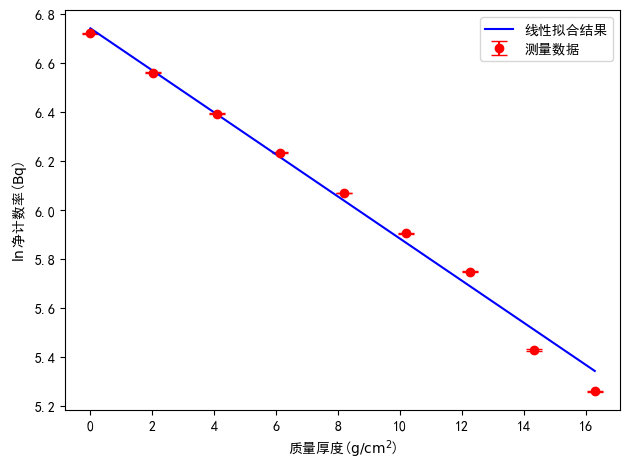

In [85]:
param,matp = from_fitting_to_plot(data_Al1['mass density'].values,np.log(data_Al1['net count rate'].values),
                     data_Al1['rate relative error'].values,
                     dot_label='测量数据',plot_label='线性拟合结果')
fig,ax=matp
ax.set_xlabel(r'质量厚度($\mathrm{g/cm^2}$)')
ax.set_ylabel(r'$\ln$净计数率($\mathrm{Bq}$)')
fig.tight_layout()
fig.savefig(path+'Al near dector.pdf')
None

#### 结果表格

In [86]:
_,_,_,rep,r2=param
num = int(-np.log10(1-r2))+1
df_result=pd.DataFrame({'拟合参数':[r'$-\mu_{\mathrm{m}}$($\mathrm{cm^2/g}$)',r'$\ln n_0$',r'决定系数$R^2$'],
                        '拟合结果':rep+[f'{r2:.{num}f}']})
print(df_result.to_latex(column_format='cc',
                         caption=r'\ce{Al} 吸收曲线对数拟合结果，几何条件为靠近探测器',
                         label='tab:Al1fitting',
                         index=False,
                         position='H'))

\begin{table}[H]
\caption{\ce{Al} 吸收曲线对数拟合结果，几何条件为靠近探测器}
\label{tab:Al1fitting}
\begin{tabular}{cc}
\toprule
拟合参数 & 拟合结果 \\
\midrule
$-\mu_{\mathrm{m}}$($\mathrm{cm^2/g}$) & $( -0.086\pm0.003 )$ \\
$\ln n_0$ & $( 6.74\pm0.02 )$ \\
决定系数$R^2$ & 0.991 \\
\bottomrule
\end{tabular}
\end{table}



## $\mathrm{Al}$-屏蔽层靠近放射源

In [87]:
data_Al2 = pd.read_excel('Data.xlsx',sheet_name='Al2')
# data_Al2 = data_Al2.drop(9)
data_Al2

,Time(s),Background,mass density incresement,mass density,count,net count,count error,relative error,net count rate,count rate error,rate relative error
0,200.0,3341.0,0.000,0.000,169574,166233,407.716813,0.002453,831.165,2.038584,0.002453
1,NaN,NaN,2.035,2.035,145679,142338,377.277087,0.002651,711.690,1.886385,0.002651
2,NaN,NaN,2.043,4.078,125088,121747,348.922628,0.002866,608.735,1.744613,0.002866
3,NaN,NaN,2.051,6.129,110330,106989,327.091730,0.003057,534.945,1.635459,0.003057
4,NaN,NaN,2.043,8.172,95759,92418,304.003289,0.003289,462.090,1.520016,0.003289
5,NaN,NaN,2.029,10.201,82236,78895,280.882538,0.003560,394.475,1.404413,0.003560
6,NaN,NaN,2.051,12.252,71228,67887,260.551339,0.003838,339.435,1.302757,0.003838
7,NaN,NaN,2.051,14.303,60638,57297,239.367918,0.004178,286.485,1.196840,0.004178
8,NaN,NaN,1.975,16.278,53949,50608,224.962219,0.004445,253.040,1.124811,0.004445
9,NaN,NaN,2.027,18.305,40598,37257,193.020724,0.005181,186.285,0.965104,0.005181


#### 数据展示

In [88]:
print(data_Al2.columns.values)
print()
formatters = {'mass density':lambda x: f'{x:.3f}',
              'net count rate':lambda x: f'{x:.1f}',
              'count rate error':lambda x: f'{x:.1f}'}
data_Al2_report = data_Al2[['mass density','count','net count rate','count rate error']]
columns=[r'质量厚度($\mathrm{{g/cm^2}}$)','总计数',r'净计数率($\mathrm{{Bq}}$)',r'误差($\mathrm{{Bq}}$)']
print(data_Al2_report.to_latex(header=columns,
                               formatters=formatters,
                               index=False,
                               column_format='cccc',
                               caption=r'\ce{Al} 吸收曲线：几何条件为靠近放射源，本底计数为 3341，本底和总计数测量时间均为 200$\operatorname{s}$',
                               label='tab:Al2',
                               position='H'))

['Time(s)' 'Background' 'mass density incresement' 'mass density' 'count'
 'net count' 'count error' 'relative error' 'net count rate'
 'count rate error' 'rate relative error']

\begin{table}[H]
\caption{\ce{Al} 吸收曲线：几何条件为靠近放射源，本底计数为 3341，本底和总计数测量时间均为 200$\operatorname{s}$}
\label{tab:Al2}
\begin{tabular}{cccc}
\toprule
质量厚度($\mathrm{g/cm^2}$) & 总计数 & 净计数率($\mathrm{Bq}$) & 误差($\mathrm{Bq}$) \\
\midrule
0.000 & 169574 & 831.2 & 2.0 \\
2.035 & 145679 & 711.7 & 1.9 \\
4.078 & 125088 & 608.7 & 1.7 \\
6.129 & 110330 & 534.9 & 1.6 \\
8.172 & 95759 & 462.1 & 1.5 \\
10.201 & 82236 & 394.5 & 1.4 \\
12.252 & 71228 & 339.4 & 1.3 \\
14.303 & 60638 & 286.5 & 1.2 \\
16.278 & 53949 & 253.0 & 1.1 \\
18.305 & 40598 & 186.3 & 1.0 \\
\bottomrule
\end{tabular}
\end{table}



#### 数据处理

In [89]:
droped_data=(data_Al2['mass density'][9],np.log(data_Al2['net count rate'][9]),data_Al2['rate relative error'][9])

第0个参数的结果为:$( -0.0731\pm0.0006 )$
第1个参数的结果为:$( 6.721\pm0.005 )$
决定系数R^2为:0.9995284568354439


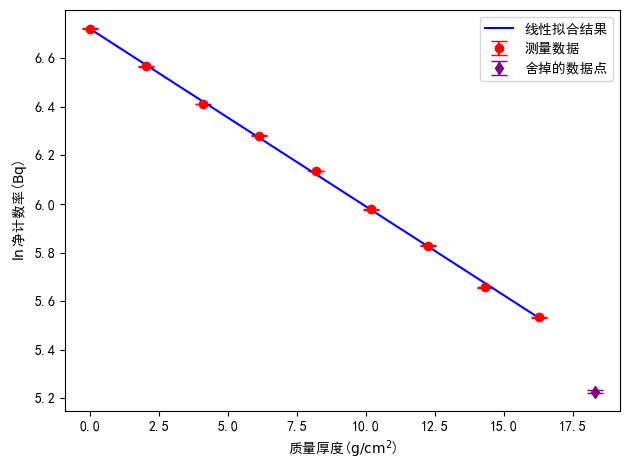

In [90]:
param,matp = from_fitting_to_plot(data_Al2.drop(9)['mass density'].values,np.log(data_Al2.drop(9)['net count rate'].values),
                     data_Al2.drop(9)['rate relative error'].values,
                     dot_label='测量数据',plot_label='线性拟合结果')

fig,ax=matp
ax.set_xlabel(r'质量厚度($\mathrm{g/cm^2}$)')
ax.set_ylabel(r'$\ln$净计数率($\mathrm{Bq}$)')
ax.errorbar(*droped_data,fmt='d',color='purple',
            markersize=6,capsize=6,
            label='舍掉的数据点')
ax.legend()
fig.tight_layout()
fig.savefig(path+'Al near source.pdf')
None

#### 结果表格

In [91]:
(mu_m_Al,_),_,_,rep,r2=param
num = int(-np.log10(1-r2))+1
df_result=pd.DataFrame({'拟合参数':[r'$-\mu_{\mathrm{m}}$($\mathrm{cm^2/g}$)',r'$\ln n_0$',r'决定系数$R^2$'],
                        '拟合结果':rep+[f'{r2:.{num}f}']})
print(df_result.to_latex(column_format='cc',
                         caption=r'\ce{Al} 吸收曲线对数拟合结果，几何条件为靠近放射源',
                         label='tab:Al2fitting',
                         index=False,
                         position='H'))
mu_m_Al = -mu_m_Al*u.cm**2/u.g
mu_m_Al

\begin{table}[H]
\caption{\ce{Al} 吸收曲线对数拟合结果，几何条件为靠近放射源}
\label{tab:Al2fitting}
\begin{tabular}{cc}
\toprule
拟合参数 & 拟合结果 \\
\midrule
$-\mu_{\mathrm{m}}$($\mathrm{cm^2/g}$) & $( -0.0731\pm0.0006 )$ \\
$\ln n_0$ & $( 6.721\pm0.005 )$ \\
决定系数$R^2$ & 0.9995 \\
\bottomrule
\end{tabular}
\end{table}



<Quantity 0.07307946 cm2 / g>

## $\mathrm{Cu}$

In [92]:
data_Cu = pd.read_excel('Data.xlsx',sheet_name='Cu')
data_Cu

,row number,Time(s),Background,mass density incresement,mass density,count,net count,count error,relative error,net count rate,count rate error,rate relative error
0,0,200.0,3040.0,3.43,0.00,156385,153345,391.592901,0.002554,766.725,1.957965,0.002554
1,1,NaN,NaN,NaN,3.43,122634,119594,345.823654,0.002892,597.970,1.729118,0.002892
2,2,NaN,NaN,NaN,6.86,95122,92082,303.450161,0.003295,460.410,1.517251,0.003295
3,3,NaN,NaN,NaN,10.29,74248,71208,266.848271,0.003747,356.040,1.334241,0.003747
4,4,NaN,NaN,NaN,13.72,58420,55380,235.329556,0.004249,276.900,1.176648,0.004249
5,5,NaN,NaN,NaN,17.15,45429,42389,205.885891,0.004857,211.945,1.029429,0.004857
6,6,NaN,NaN,NaN,20.58,39165,36125,190.065778,0.005261,180.625,0.950329,0.005261
7,7,NaN,NaN,NaN,24.01,28578,25538,159.806133,0.006258,127.690,0.799031,0.006258
8,8,NaN,NaN,NaN,27.44,22833,19793,140.687597,0.007108,98.965,0.703438,0.007108
9,9,NaN,NaN,NaN,30.87,18365,15325,123.794184,0.008078,76.625,0.618971,0.008078


#### 数据展示

In [93]:
print(data_Cu.columns.values)
print()
formatters = {'mass density':lambda x: f'{x:.2f}',
              'net count rate':lambda x: f'{x:.1f}',
              'count rate error':lambda x: f'{x:.1f}'}
data_Cu_report = data_Cu[['mass density','count','net count rate','count rate error']]
columns=[r'质量厚度($\mathrm{{g/cm^2}}$)','总计数',r'净计数率($\mathrm{{Bq}}$)',r'误差($\mathrm{{Bq}}$)']
print(data_Cu_report.to_latex(header=columns,
                               formatters=formatters,
                               index=False,
                               column_format='cccc',
                               caption=r'\ce{Cu} 吸收曲线：几何条件为靠近放射源，本底计数为 3040，本底和总计数测量时间均为 200$\operatorname{s}$',
                               label='tab:Cu',
                               position='H'))

['row number' 'Time(s)' 'Background' 'mass density incresement'
 'mass density' 'count' 'net count' 'count error' 'relative error'
 'net count rate' 'count rate error' 'rate relative error']

\begin{table}[H]
\caption{\ce{Cu} 吸收曲线：几何条件为靠近放射源，本底计数为 3040，本底和总计数测量时间均为 200$\operatorname{s}$}
\label{tab:Cu}
\begin{tabular}{cccc}
\toprule
质量厚度($\mathrm{g/cm^2}$) & 总计数 & 净计数率($\mathrm{Bq}$) & 误差($\mathrm{Bq}$) \\
\midrule
0.00 & 156385 & 766.7 & 2.0 \\
3.43 & 122634 & 598.0 & 1.7 \\
6.86 & 95122 & 460.4 & 1.5 \\
10.29 & 74248 & 356.0 & 1.3 \\
13.72 & 58420 & 276.9 & 1.2 \\
17.15 & 45429 & 211.9 & 1.0 \\
20.58 & 39165 & 180.6 & 1.0 \\
24.01 & 28578 & 127.7 & 0.8 \\
27.44 & 22833 & 99.0 & 0.7 \\
30.87 & 18365 & 76.6 & 0.6 \\
\bottomrule
\end{tabular}
\end{table}



#### 数据处理

第0个参数的结果为:$( -0.0739\pm0.0008 )$
第1个参数的结果为:$( 6.643\pm0.010 )$
决定系数R^2为:0.9990533676769979


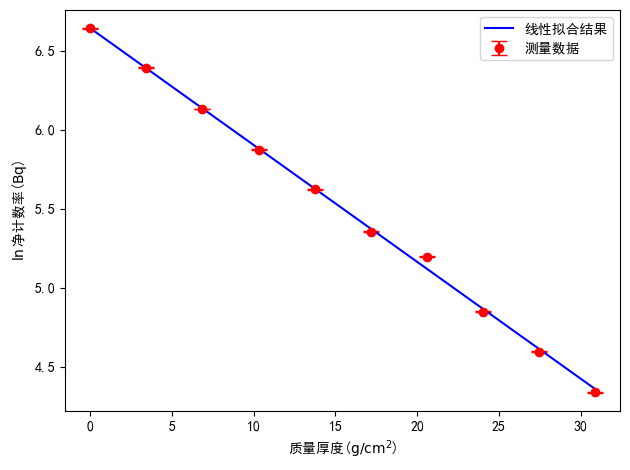

In [94]:
param,matp = from_fitting_to_plot(data_Cu['mass density'].values,np.log(data_Cu['net count rate'].values),
                     data_Cu['rate relative error'].values,
                     dot_label='测量数据',plot_label='线性拟合结果')

fig,ax=matp
ax.set_xlabel(r'质量厚度($\mathrm{g/cm^2}$)')
ax.set_ylabel(r'$\ln$净计数率($\mathrm{Bq}$)')
fig.tight_layout()
fig.savefig(path+'Cu near source.pdf')
None

#### 结果表格

In [95]:
(mu_m_Cu,_),_,_,rep,r2=param
num = int(-np.log10(1-r2))+1
df_result=pd.DataFrame({'拟合参数':[r'$-\mu_{\mathrm{m}}$($\mathrm{cm^2/g}$)',r'$\ln n_0$',r'决定系数$R^2$'],
                        '拟合结果':rep+[f'{r2:.{num}f}']})
print(df_result.to_latex(column_format='cc',
                         caption=r'\ce{Cu} 吸收曲线对数拟合结果，几何条件为靠近放射源',
                         label='tab:Cufitting',
                         index=False,
                         position='H'))
mu_m_Cu = -mu_m_Cu*u.cm**2/u.g
mu_m_Cu

\begin{table}[H]
\caption{\ce{Cu} 吸收曲线对数拟合结果，几何条件为靠近放射源}
\label{tab:Cufitting}
\begin{tabular}{cc}
\toprule
拟合参数 & 拟合结果 \\
\midrule
$-\mu_{\mathrm{m}}$($\mathrm{cm^2/g}$) & $( -0.0739\pm0.0008 )$ \\
$\ln n_0$ & $( 6.643\pm0.010 )$ \\
决定系数$R^2$ & 0.9991 \\
\bottomrule
\end{tabular}
\end{table}



<Quantity 0.07391779 cm2 / g>

## 匠心手造(shimingnanwei)

In [96]:
jiangxinshouzao = data_Al2.drop(9)[['mass density']]
ydata = np.log(data_Al2['net count rate'].drop(9).values)
yerror = data_Al2['rate relative error'].drop(9).values
xdata = data_Al2['mass density'].drop(9).values
jiangxinshouzao['ln rate'] = ydata
jiangxinshouzao['error of ln rate'] = yerror
weight = 1/yerror**2
jiangxinshouzao['weight'] = weight
jiangxinshouzao

,mass density,ln rate,error of ln rate,weight
0,0.000,6.722828,0.002453,166233.0
1,2.035,6.567642,0.002651,142338.0
2,4.078,6.411383,0.002866,121747.0
3,6.129,6.282164,0.003057,106989.0
4,8.172,6.135760,0.003289,92418.0
5,10.201,5.977556,0.003560,78895.0
6,12.252,5.827282,0.003838,67887.0
7,14.303,5.657686,0.004178,57297.0
8,16.278,5.533548,0.004445,50608.0


In [97]:
formatters = {'mass density':lambda x: f'{x:.3f}',
              'ln rate':lambda x: f'{x:.4f}',
              'error of ln rate':lambda x: f'{x:.4f}',
              'weight':lambda x: f'{x/1000:.1f}'}
print(jiangxinshouzao.to_latex(header=[r'质量厚度$x_i$',
                                       r'计数率对数值$y_i$',
                                       r'误差$\sigma_{{y_i}}$',
                                       r'权重$w_i$($\times 10^3$)'],
                               column_format='cccc',
                               formatters=formatters,
                               caption='手工拟合计算',
                               label='tab:jiangxin',
                               index=False),)


\begin{table}
\caption{手工拟合计算}
\label{tab:jiangxin}
\begin{tabular}{cccc}
\toprule
质量厚度$x_i$ & 计数率对数值$y_i$ & 误差$\sigma_{y_i}$ & 权重$w_i$($\times 10^3$) \\
\midrule
0.000 & 6.7228 & 0.0025 & 166.2 \\
2.035 & 6.5676 & 0.0027 & 142.3 \\
4.078 & 6.4114 & 0.0029 & 121.7 \\
6.129 & 6.2822 & 0.0031 & 107.0 \\
8.172 & 6.1358 & 0.0033 & 92.4 \\
10.201 & 5.9776 & 0.0036 & 78.9 \\
12.252 & 5.8273 & 0.0038 & 67.9 \\
14.303 & 5.6577 & 0.0042 & 57.3 \\
16.278 & 5.5335 & 0.0044 & 50.6 \\
\bottomrule
\end{tabular}
\end{table}



In [98]:
n = len(xdata)
ww = weight.sum()
wx = (weight*xdata).sum()
wy = (weight*ydata).sum()
wxx = (weight*xdata**2).sum()
wxy = (weight*xdata*ydata).sum()
a = (ww*wxy-wx*wy)/(ww*wxx-wx**2)
b = (wy*wxx-wxy*wx)/(ww*wxx-wx**2)
fitting = np.vectorize(lambda x:a*x+b)
yhat = fitting(xdata)
sigy = np.sqrt((weight*(yhat - ydata)**2).sum()/(n-2))
siga = np.sqrt(ww/(ww*wxx-wx**2))*sigy
sigb = np.sqrt(wxx/(ww*wxx-wx**2))*sigy

# print(a,b)
gethigh = lambda x:int(np.floor(np.log10(abs(x))))
getcode = lambda x,name:fr'{name}={x/10**gethigh(x):.3f}\times 10^{{{gethigh(x)}}}'
print(getcode(ww,r'[\omega]'),end=',')
print(getcode(wx,r'[\omega x]'),end=r'\\'+'\n')
print(getcode(wxx,r'[\omega x^2]'),end=',')
print(getcode(wxy,r'[\omega xy]'),end=r'\\'+'\n')
print(getcode(a,r'a=\frac{[\omega][\omega x y]-[\omega x][\omega y]}{[\omega]\left[\omega x^2\right]-[\omega x]^2}'),end=r'\\'+'\n')
print(getcode(b,r'b=\frac{[\omega y]\left[ \omega x^{2}\right] -[\omega xy][\omega x]}{[\omega ]\left[ \omega x^{2}\right] -[\omega x]^{2}}'),end=r'\\'+'\n')
print(getcode(sigy,r'\sigma_y=\sqrt{\frac{\left[ \omega ( y-\hat{y})^{2}\right]}{k-2}}'),end=r'\\'+'\n')
print(getcode(siga,r'\sigma_a=\sqrt{\frac{[\omega ]}{[\omega ]\left[ \omega x^{2}\right] -[\omega x]^{2}}} \sigma _{y}'),end=r'\\'+'\n')
print(getcode(sigb,r'\sigma_b=\sqrt{\frac{\left[ \omega x^{2}\right]}{[\omega ]\left[ \omega x^{2}\right] -[\omega x]^{2}}} \sigma _{y}'))

[\omega]=8.844\times 10^{5},[\omega x]=5.477\times 10^{6}\\
[\omega x^2]=5.634\times 10^{7},[\omega xy]=3.269\times 10^{7}\\
a=\frac{[\omega][\omega x y]-[\omega x][\omega y]}{[\omega]\left[\omega x^2\right]-[\omega x]^2}=-7.308\times 10^{-2}\\
b=\frac{[\omega y]\left[ \omega x^{2}\right] -[\omega xy][\omega x]}{[\omega ]\left[ \omega x^{2}\right] -[\omega x]^{2}}=6.721\times 10^{0}\\
\sigma_y=\sqrt{\frac{\left[ \omega ( y-\hat{y})^{2}\right]}{k-2}}=2.960\times 10^{0}\\
\sigma_a=\sqrt{\frac{[\omega ]}{[\omega ]\left[ \omega x^{2}\right] -[\omega x]^{2}}} \sigma _{y}=6.251\times 10^{-4}\\
\sigma_b=\sqrt{\frac{\left[ \omega x^{2}\right]}{[\omega ]\left[ \omega x^{2}\right] -[\omega x]^{2}}} \sigma _{y}=4.989\times 10^{-3}


In [99]:
jiangxinshouzao

,mass density,ln rate,error of ln rate,weight
0,0.000,6.722828,0.002453,166233.0
1,2.035,6.567642,0.002651,142338.0
2,4.078,6.411383,0.002866,121747.0
3,6.129,6.282164,0.003057,106989.0
4,8.172,6.135760,0.003289,92418.0
5,10.201,5.977556,0.003560,78895.0
6,12.252,5.827282,0.003838,67887.0
7,14.303,5.657686,0.004178,57297.0
8,16.278,5.533548,0.004445,50608.0


## $\mathrm{Pb}$

In [100]:
mu_Pb = 1.213*u.cm**-1
rho_Al = 2.6989 *u.g*u.cm**-3
rho_Cu = 8.93*u.g*u.cm**-3	
mu_Al = mu_m_Al*rho_Al
mu_Cu = mu_m_Cu*rho_Cu

mu_list = [mu_Al.value,mu_Cu.to(mu_Al.unit).value,mu_Pb.to(mu_Al.unit).value]*mu_Al.unit
thick_1_10 = np.log(10)/mu_list
df = pd.DataFrame({'Type of metal':[r'\ce{Al}',r'\ce{Cu}',r'\ce{Pb}'],
                   f'linear attenuation coefficient({mu_list.unit})':mu_list,
                   f'1/10-value thickness({thick_1_10.unit})':thick_1_10})


formatters = {f'linear attenuation coefficient({mu_list.unit})':lambda x: f'{x:.4f}',
              f'1/10-value thickness({thick_1_10.unit})':lambda x: f'{x:.3f}'}
print(df.to_latex(index=False,
      header=[r'屏蔽层材料',
              r'线性吸收系数(\unit{{cm^{{-1}}}})',
              r'1/10吸收厚度(\unit{{cm}})'],
      column_format='ccc',
      caption='三种屏蔽材料的防护能力对比',
      label='tab:lead',
      formatters=formatters))

\begin{table}
\caption{三种屏蔽材料的防护能力对比}
\label{tab:lead}
\begin{tabular}{ccc}
\toprule
屏蔽层材料 & 线性吸收系数(\unit{cm^{-1}}) & 1/10吸收厚度(\unit{cm}) \\
\midrule
\ce{Al} & 0.1972 & 11.674 \\
\ce{Cu} & 0.6601 & 3.488 \\
\ce{Pb} & 1.2130 & 1.898 \\
\bottomrule
\end{tabular}
\end{table}

